In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 4.2MB/s 


In [3]:
# Import required packages, libraries and classes for the project

import numpy as np
np.random.seed(1)

import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
import keras
plt.style.use('default')
from keras.layers import Dense, Dropout
import kerastuner as kt

### Data Preprocessing

In [4]:
# Load the Dataset
df = pd.read_csv("/content/drive/My Drive/stockRAKPROP.csv",parse_dates = True,index_col=0)
df.head()

,Open,High,Low,Volume,SMA,EMA,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH,STOCHD,Close
Date,,,,,,,,,,,,,,,
2014-06-15,1.10,1.11,1.06,13250000.0,0.990952,1.008244,0.17,54.520264,-1.851852,0.009229,0.9890,-3.163401e+07,86.111111,88.299663,1.06
2014-06-16,1.07,1.07,1.02,17000000.0,0.991905,1.003068,0.20,52.260883,-6.363636,0.005551,0.9875,-3.013509e+07,84.848485,90.909091,1.03
2014-06-17,1.02,1.06,1.02,14770000.0,0.995238,1.000375,0.22,54.856310,-5.357143,0.003829,0.9900,-3.007993e+07,93.939394,93.939394,1.06
2014-06-18,1.06,1.07,1.04,6800000.0,0.998095,0.994413,0.10,54.856310,-4.504505,-0.001478,0.9920,-3.370621e+07,93.939394,92.929293,1.06
2014-06-19,1.06,1.08,1.06,19480000.0,1.000476,0.987854,0.05,54.856310,6.000000,-0.008231,0.9950,-3.462068e+07,93.939394,87.422613,1.06


In [5]:
# Correlation Matrix
df.corr()['Close']

Open       0.995513
High       0.997637
Low        0.997192
Volume     0.317317
SMA        0.974454
EMA        0.981913
MOM        0.184567
RSI        0.228810
ROC        0.185943
MACD       0.329849
BB         0.975488
CHAIKIN   -0.424417
STOCH      0.088506
STOCHD     0.086778
Close      1.000000
Name: Close, dtype: float64

In [6]:
# Extracting the features for the LSTM model
series = df[["Close",	"MOM",	"RSI",	"ROC",	"MACD",	"BB",	"CHAIKIN",	"STOCH"]]
print(series.shape)
series.head()

(1467, 8)


,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2014-06-15,1.06,0.17,54.520264,-1.851852,0.009229,0.9890,-3.163401e+07,86.111111
2014-06-16,1.03,0.20,52.260883,-6.363636,0.005551,0.9875,-3.013509e+07,84.848485
2014-06-17,1.06,0.22,54.856310,-5.357143,0.003829,0.9900,-3.007993e+07,93.939394
2014-06-18,1.06,0.10,54.856310,-4.504505,-0.001478,0.9920,-3.370621e+07,93.939394
2014-06-19,1.06,0.05,54.856310,6.000000,-0.008231,0.9950,-3.462068e+07,93.939394


In [7]:
# Normalisation
sc_X = StandardScaler()
series.iloc[:,1:] = sc_X.fit_transform(series.iloc[:,1:])
sc_y = StandardScaler()
series[['Close']] = sc_y.fit_transform(series[['Close']])
series

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2014-06-15,2.854058,3.737399,0.281264,-0.409551,0.454591,2.476301,-1.835892,1.067338
2014-06-16,2.657587,4.415003,0.014683,-0.898457,0.181178,2.466235,-1.703946,1.026178
2014-06-17,2.854058,4.866739,0.320913,-0.789391,0.053229,2.483011,-1.699090,1.322527
2014-06-18,2.854058,2.156323,0.320913,-0.696998,-0.341246,2.496432,-2.018303,1.322527
2014-06-19,2.854058,1.026983,0.320913,0.441289,-0.843141,2.516563,-2.098802,1.322527
...,...,...,...,...,...,...,...,...
2020-05-05,-1.795765,-0.170117,-0.134290,-0.391514,-0.191906,-1.850583,0.650931,-0.290927
2020-05-06,-1.821961,-0.124943,-0.398894,-0.332723,-0.208115,-1.847228,0.665667,-0.109825
2020-05-07,-1.841608,-0.079770,-0.603226,-0.575175,-0.202471,-1.843873,0.653563,-0.159217


In [8]:
series.tail()

,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2020-05-05,-1.795765,-0.170117,-0.134290,-0.391514,-0.191906,-1.850583,0.650931,-0.290927
2020-05-06,-1.821961,-0.124943,-0.398894,-0.332723,-0.208115,-1.847228,0.665667,-0.109825
2020-05-07,-1.841608,-0.079770,-0.603226,-0.575175,-0.202471,-1.843873,0.653563,-0.159217
2020-05-10,-1.776117,0.100925,0.063560,-0.084684,-0.175721,-1.841524,0.606076,0.828613
2020-05-11,-1.848157,0.236445,-0.740708,-0.546553,-0.207912,-1.840853,0.566592,-0.258000


In [9]:
# Train/Test Data Split
train_start = dt.date(2014,5,15)
train_end = dt.date(2020,3,1)
train_data = series.loc[train_start:train_end]

test_start = dt.date(2020,3,2)
test_end = dt.date(2020,6,14)
test_data = series.loc[test_start:test_end]

print(train_data.shape,test_data.shape)

(1416, 8) (51, 8)


In [10]:
train = train_data.values
val = test_data.values

In [11]:
# Setting up an Early Stopping function
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]
RMSE = keras.metrics.RootMeanSquaredError()

In [12]:
#Build and train the model
def fit_model(train,val,timesteps,lr,batch,epochs,dropout,units):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    hl = units
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error',
                  metrics=[RMSE,'mse', 'mae', 'mape'])
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,
                        validation_data = (X_val, Y_val),verbose = 2,
                        shuffle = False, callbacks=callbacks_list)
    mse = history.history['val_mse'][-1]
    mae = history.history['val_mae'][-1]
    mape = history.history['val_mape'][-1]
    rmse = history.history["val_root_mean_squared_error"][-1]
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss'],\
     rmse, mse, mae, mape


In [13]:
X_train = []
Y_train = []
X_val = []
Y_val = []
timesteps = 45
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

# Loop for val data
for i in range(timesteps,val.shape[0]):
    X_val.append(val[i-timesteps:i])
    Y_val.append(val[i][0])
X_val,Y_val = np.array(X_val),np.array(Y_val)

In [14]:
from keras import backend as K
from keras.losses import mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

In [15]:
def model_builder(hp):
  # Define the ConvLSTM Model
  model = keras.Sequential()
  model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))

  # Tune the number of units in the first Dense layer
  hp_units = hp.Int('units', min_value = 16, max_value = 64, step = 8)
  model.add(LSTM(units = hp_units,activation = 'relu',return_sequences = True))
  model.add(LSTM(units = hp_units,activation = 'relu'))

  hp_dropout = hp.Float('dropout', min_value = .2, max_value = .5, step = .1)
  model.add(Dropout(rate = hp_dropout))
  model.add(Dense(1))
  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  hp_batch = hp.Choice('batch_size', values = [8,16,64])

  model.compile(optimizer = optimizers.Adam(learning_rate = hp_learning_rate),
                loss = root_mean_squared_error,
                metrics=[root_mean_squared_error,'mse', 'mae', 'mape'])
  
  return model


In [16]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 50,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

In [17]:
import tensorflow as tf
import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [18]:
tuner.search(X_train, Y_train, epochs = 10, validation_data = (X_val, Y_val), callbacks = [ClearTrainingOutput()])


Trial 90 Complete [00h 01m 29s]
val_loss: 0.5611429810523987

Best val_loss So Far: 0.021841764450073242
Total elapsed time: 00h 37m 59s
INFO:tensorflow:Oracle triggered exit


In [19]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete.\nThe optimal number of units in the first densely-connected layer is {best_hps.get('units')}\n
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}\n
The best dropout is {best_hps.get('dropout')}\n
The best batch size is {best_hps.get('batch_size')}\n
The best num of epochs is {best_hps.get('tuner/epochs')}.
""")


The hyperparameter search is complete.
The optimal number of units in the first densely-connected layer is 40

The optimal learning rate for the optimizer is 0.001

The best dropout is 0.30000000000000004

The best batch size is 8

The best num of epochs is 2.



In [20]:
tuner.results_summary(num_trials=90)

Results summary
Results in my_dir/intro_to_kt
Showing 90 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 40
dropout: 0.30000000000000004
learning_rate: 0.001
batch_size: 8
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.021841764450073242
Trial summary
Hyperparameters:
units: 24
dropout: 0.30000000000000004
learning_rate: 0.001
batch_size: 8
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 5eeeeb70edbe20afa613b0cd95bff492
Score: 0.02266238071024418
Trial summary
Hyperparameters:
units: 56
dropout: 0.5000000000000001
learning_rate: 0.001
batch_size: 16
tuner/epochs: 6
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.022858282551169395
Trial summary
Hyperparameters:
units: 48
dropout: 0.2
learning_rate: 0.001
batch_size: 8
tuner/epochs: 6
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.023770233616232872
Trial summary
Hyperparameters:
units:

In [21]:
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, Y_train, epochs = 50, validation_data = (X_val, Y_val))

Epoch 1/50
43/43 [==============================] - 5s 56ms/step - loss: 0.5537 - root_mean_squared_error: 0.5537 - mse: 0.5581 - mae: 0.5537 - mape: 94.8293 - val_loss: 0.2529 - val_root_mean_squared_error: 0.2529 - val_mse: 0.0651 - val_mae: 0.2529 - val_mape: 14.0366
Epoch 2/50
43/43 [==============================] - 2s 45ms/step - loss: 0.2301 - root_mean_squared_error: 0.2301 - mse: 0.1174 - mae: 0.2301 - mape: 72.0221 - val_loss: 0.4376 - val_root_mean_squared_error: 0.4376 - val_mse: 0.1926 - val_mae: 0.4376 - val_mape: 24.2453
Epoch 3/50
43/43 [==============================] - 2s 46ms/step - loss: 0.1919 - root_mean_squared_error: 0.1919 - mse: 0.0699 - mae: 0.1919 - mape: 61.9204 - val_loss: 0.2973 - val_root_mean_squared_error: 0.2973 - val_mse: 0.0896 - val_mae: 0.2973 - val_mape: 16.4795
Epoch 4/50
43/43 [==============================] - 2s 48ms/step - loss: 0.1611 - root_mean_squared_error: 0.1611 - mse: 0.0507 - mae: 0.1611 - mape: 52.9684 - val_loss: 0.6108 - val_root

In [22]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Close')
    plt.title('Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [23]:
# Plotting the training errors
def plot_loss(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [24]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    
    # Prediction Time 
    Y_hat = model.predict(X_test)
    return Y_test, Y_hat

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 45, 8)             544       
_________________________________________________________________
lstm_1 (LSTM)                (None, 45, 40)            7840      
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 21,385
Trainable params: 21,385
Non-trainable params: 0
_________________________________________________________________


In [26]:
y_pred = model.predict(X_val)
y_true = np.array([Y_val]).T

mae = tf.keras.losses.MeanAbsoluteError()
mae = mae(y_true, y_pred).numpy()

mape = tf.keras.losses.MeanAbsolutePercentageError()
mape = mape(y_true, y_pred).numpy()

mse = tf.keras.losses.MeanSquaredError()
mse = mse(y_true, y_pred).numpy()

rmse = sqrt(mse)

In [33]:
print('MSE = {}'.format(round(mse, 5)))
print('RMSE = {}'.format(round(rmse, 5)))
print('MAPE = {}'.format(round(mape, 5)))
print('MAE = {}'.format(round(mae, 5)))

MSE = 0.024650000035762787
RMSE = 0.15702
MAPE = 8.578550338745117
MAE = 0.15452000498771667


In [28]:
true,predicted = evaluate_model(model,val,timesteps)

In [29]:
train_date = df['2014-05-15' : '2020-03-1'].index
test_date = df['2020-03-2' :].index
pred_date = df['2020-03-2' :].index[45:]

In [30]:
Y_train = sc_y.inverse_transform(np.array([train[:,0]]))
Y_test = sc_y.inverse_transform(np.array([val[:,0]]))
Y_pred = sc_y.inverse_transform(predicted.T)

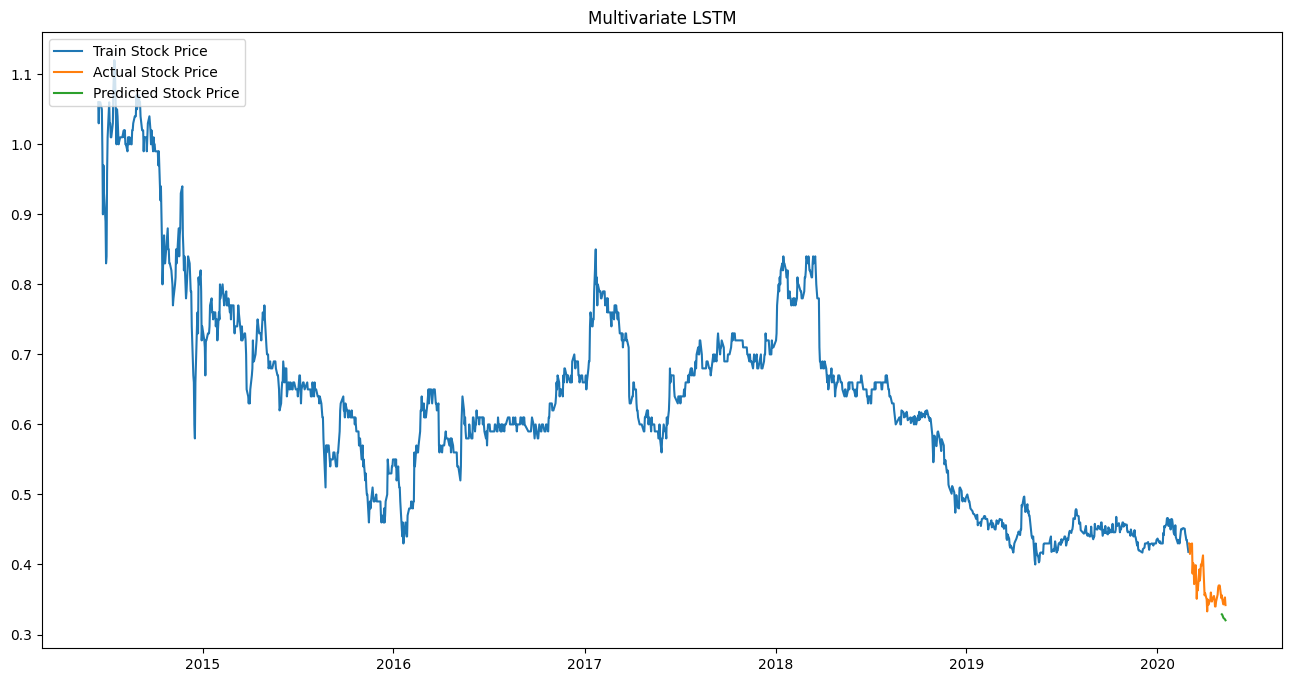

In [31]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

plt.figure(figsize=(16,8))
price_close_train = Y_train[0]
price_close_test = Y_test[0]
plt.plot(train_date, price_close_train, label = "Train Stock Price")
plt.plot(test_date, price_close_test, label = "Actual Stock Price")
plt.plot(pred_date, Y_pred[0], label = "Predicted Stock Price")

plt.title("Multivariate LSTM")
plt.legend(loc='upper left')
#plt.tight_layout()

plt.show()

In [32]:
# Save a model
model.save('MV-LSTM_dataset4_hyperband.h5')